In [1]:
import numpy as np               # well, it's numpy.. powerful array and numerical computation tool (python's matlab)
import matplotlib.pyplot as plt  # well, it's matplotlib.. for data visualization.. plotting
import segyio                    # to easily read segy, but if you got 'abnormal' segy format, I suggest reading it manually (see my other tutorial)
import cv2                       # for image manipulation
import torch                     # pytorch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import albumentations as A                           #for data augmentation
from torch.utils.data import Dataset, DataLoader     #for making a dataset
from sklearn.metrics import f1_score,accuracy_score  #for score metric calculation

Now let's read the data just like the notebook from equinor :

In [3]:
def segy2numpy(filename: str) -> np.array:
    with segyio.open(filename, xline=181) as segyfile:
        return segyio.tools.cube(segyfile)

data = segy2numpy('issap20_Pp.sgy').transpose(2, 1, 0)
label = segy2numpy('issap20_Fault.sgy').transpose(2, 1, 0)

so, the 3D data is consist of :

In [4]:
print("xline : ", data.shape[1])
print("inline : ", data.shape[2])
print("sample : ", data.shape[0])

xline :  589
inline :  101
sample :  751


let's viz a slice :

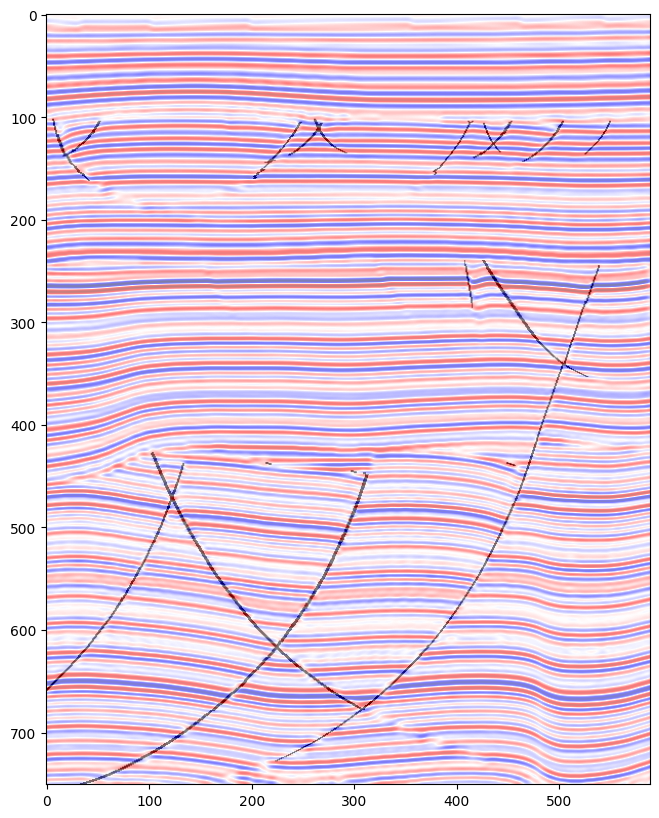

In [5]:
inline=50
fig = plt.figure(figsize=(10,10))
plt.imshow(data[:,:,inline], cmap='seismic')
plt.imshow(label[:,:,inline],cmap='Greys',  vmin=0, vmax=1, alpha=0.5)
plt.show()

In [103]:
def tns(trace,nc):
    return int(len(trace)/nc)

def seg_from_trace(trace,nc):
    ns=tns(trace,nc)
    tr=trace[0:ns*nc]
    tr=np.reshape(tr,(nc,ns))
    tr=np.transpose(tr)
    return tr
def trace_from_seg(seg):
    seg=np.transpose(seg)
    return np.reshape(seg,(seg.shape[0]*seg.shape[1],1)).flatten()



In [107]:
trace=np.array(range(750)).flatten()
nc=25
seg=seg_from_trace(trace,nc)

trace2=trace_from_seg(seg)
print(seg.shape,trace2.shape,trace.shape)
print(trace2[0:60])
print(seg[:,0])

(30, 25) (750,) (750,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [109]:
def image_to_segs(img,nc):
    ntr=img.shape[1]
    ns=img.shape[0]//nc
    img_seg=np.zeros((ns,nc,ntr)) 
    for i in range(ntr):
        img_seg[:,:,i]=seg_from_trace(img[:,i],nc)
    return img_seg
    

In [114]:
impr=data[:,:,inline]
pr=seg_from_trace(impr[:,2],nc)
print(pr.shape)
impr_label=label[:,:,inline]

impr_seg=image_to_segs(impr,25)
impr_label_seg=image_to_segs(impr_label,25)
print(impr_seg.shape)
print(impr_label_seg.shape)
# impr_label_seg=image_to_deg(impr_label,nc)


(30, 25)
(30, 25, 589)
(30, 25, 589)


In [111]:
def segs_to_image(impr_seg):
    ns=impr_seg.shape[0]
    nc=impr_seg.shape[1]
    ntr=impr_seg.shape[2]
    img=np.zeros((ns*nc,ntr))
    for i in range(ntr):
        img[:,i]=trace_from_seg(impr_seg[:,:,i])
    return img

(750, 589)
(750, 589)


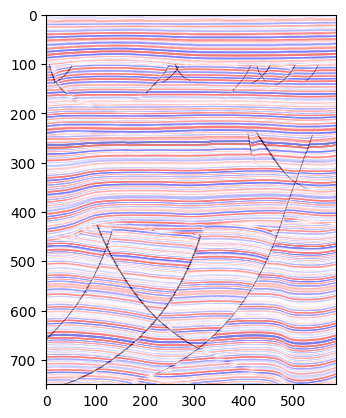

In [112]:
img_deg=segs_to_image(impr_seg)
img_label_deg=segs_to_image(impr_label_seg)
print(img_deg.shape)
print(img_label_deg.shape)
plt.imshow(img_deg,cmap='seismic')
plt.imshow(img_label_deg,cmap='Greys',  vmin=0, vmax=1, alpha=0.5)
plt.show()



In [119]:
print(impr_label_seg.shape)
pr=np.zeros_like(impr_label_seg)
for j in range(impr_label_seg.shape[2]):
    for i in range(impr_label_seg.shape[1]):
        s=impr_label_seg[:,i,j] 
        s=s.sum()
        pr[15,i,j]=s

(30, 25, 589)


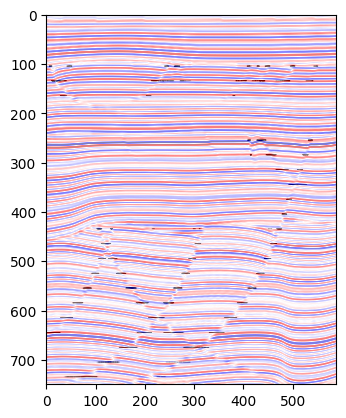

In [121]:
pr_img=segs_to_image(pr)
plt.imshow(img_deg,cmap='seismic')
plt.imshow(pr_img,cmap='Greys',  vmin=0, vmax=1, alpha=0.5)
plt.show()


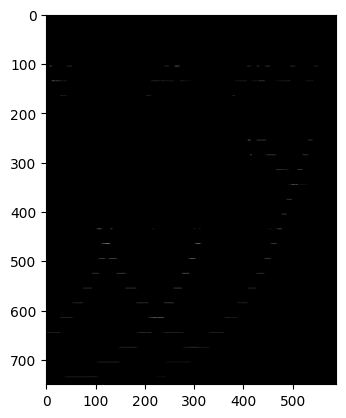

In [124]:
plt.imshow(pr_img,cmap='gray')
plt.show()

(30, 25)


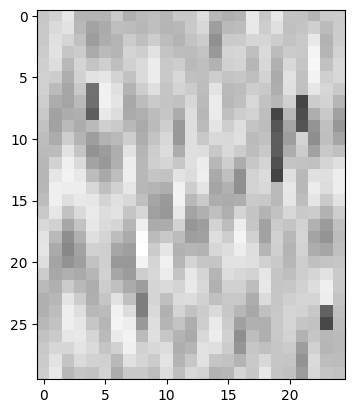

In [6]:
impr=data[:,:,inline]
impr_label=label[:,:,inline]
ltr=data.shape[0]
N=250
fc=int(ltr/30)
fcr=fc*30 
trl=impr_label[1:fcr+1,N]
tr=impr[1:fcr+1,N]

tr=np.reshape(tr,(25,30))
tr=np.transpose(tr) 
trl=np.reshape(trl,(25,30))
trl=np.transpose(trl)
print(tr.shape)
plt.imshow(tr,cmap='Greys')
plt.imshow(trl,cmap='Greys',alpha=0.5)


[ 0  1  2  3  4  5  6  7  8  9 10 11]


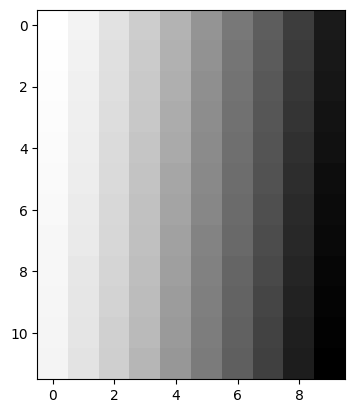

In [7]:
pr=np.zeros(120)
pr=range(120)
pr=np.reshape(pr,(10,12))
pr=pr.T
print(pr[:,0])
plt.imshow(pr,cmap='Greys')


Now let's split the data the first 80 inlines for training and the rest for test.


In [73]:
data_train=data[:,:,:80]
label_train=label[:,:,:80]
data_test=data[:,:,80:]
label_test=label[:,:,80:]

In [74]:
print(data_train.shape)
print(data_test.shape)

(751, 589, 80)
(751, 589, 21)


Why not randomly splitting between inlines?

My suggestion, for data from the same cube seismic, is don't. You'll get the prediction score high because it is easy to predict what between data that is known.

It is better to get test data from different part area of the cube, or even different seismic cube.

Ok, the next step is making the dataset.

dataset is a class that consist of `__init__`, `__len__` (length of data), `__get__` item (data that we will fetch).

If you got limited ram, this step is really useful because we can only load it when the batch of data called by reading it from the `__get__` part.

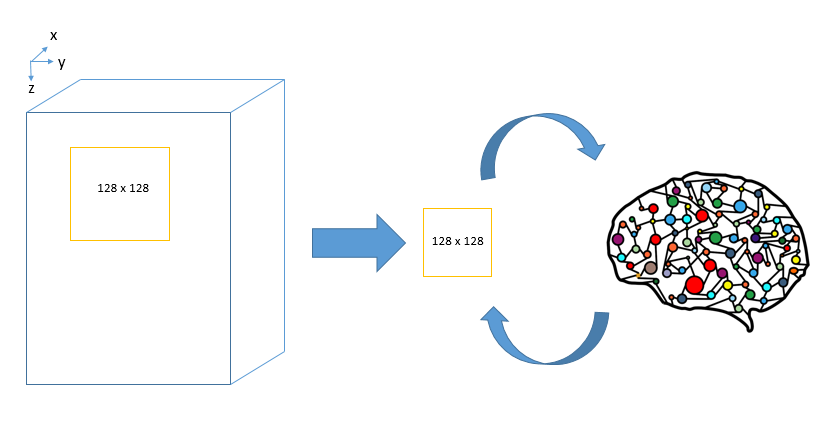

Okay, before we got further, VRAM on GPU is limited.

So either we resize our training data, or we fed it to the model patch by patch (also when predicting).

In this tutorial, we try to make it patch by patch.

For the train part, this program below is something like this :
1. Get one slice
2. Do the augmentation by certain probability, so you get 'new' data.
3. Crop it into 128x128

We'll try it like this because we want to use our limited data fully by making a lot of new data from augmentation.

In [75]:
class seisdataset_train(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X.astype('float32')
        self.y = y.astype('float32')
        self.aug = A.Compose([
            A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=0.30, rotate_limit=30) ,
            A.HorizontalFlip(p=0.2),
            A.RandomCrop(p=1, height=128, width=128),
        ])

    def __len__(self):
        return self.X.shape[2]

    def __getitem__(self,index):
        data = self.X[:,:,index]
        label = self.y[:,:,index]
        data_aug = self.aug(image=data, mask=label)
        data, label = data_aug['image'], data_aug['mask']
        return data[None,:,:], label

Now let's test our dataset if it is working as expected.

In [76]:
train_data = seisdataset_train(data_train, label_train)

In [77]:
print(train_data.aug[0])

ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(0, 0), shift_limit_y=(0, 0), scale_limit=(-0.30000000000000004, 0.30000000000000004), rotate_limit=(-30, 30), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box')


In [10]:
print(train_data[0][0].shape)
print(train_data[79][1].shape)
print(train_data[0][0].dtype)
print(train_data[0][1].dtype)
print(train_data.__len__())

(1, 128, 128)
(128, 128)
float32
float32
80


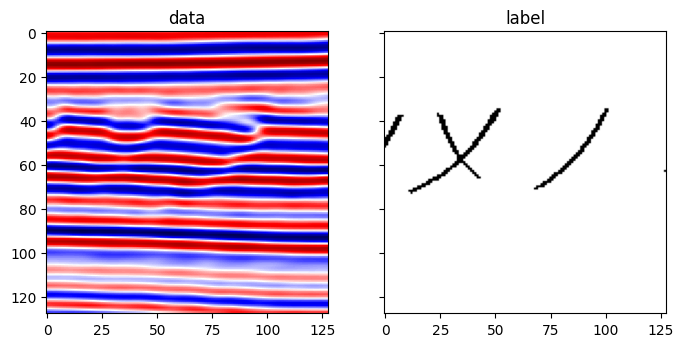

In [116]:
no_sample = 40
data_get = train_data[no_sample]
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,8))
ax[0].imshow(data_get[0][0,:,:], cmap='seismic')
ax[1].imshow(data_get[1], cmap='Greys')
ax[0].set_title('data')
ax[1].set_title('label')
plt.show()

In [146]:
no_sample = 0
data_get = train_data[no_sample]
img=data_get[0][0,:,:]
la=data_get[1]
train_np=np.zeros((128,128,80*50))
label_np=np.zeros((128,128,80*50))
for i in range(80):
    for j in range(50):
        data_get = train_data[i]
        train_np[:,:,i*50+j]=data_get[0][0,:,:]
        label_np[:,:,i*50+j]=data_get[1]



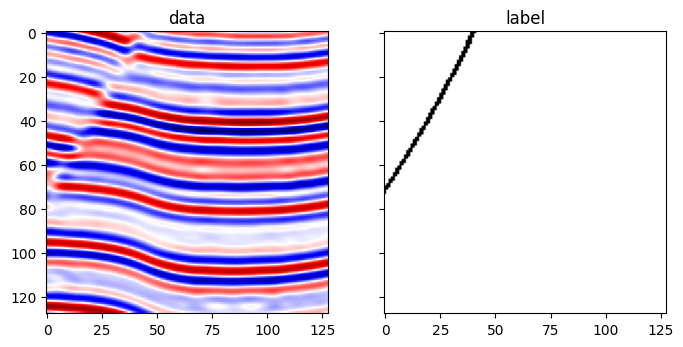

In [152]:
i=3999
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,8))
ax[0].imshow(train_np[:,:,i], cmap='seismic')
ax[1].imshow(label_np[:,:,i], cmap='Greys')
ax[0].set_title('data')
ax[1].set_title('label')
plt.show()

It's working!

Now, For the test part, because it is a test phase, we are going to predict every test sample patch by patch.

You can do it by using the dataset class (but it'll be quite a work), or tile the data before using it.

In this tutorial we are going to tile the test set into 128x128 size before (because it's easier hehe)

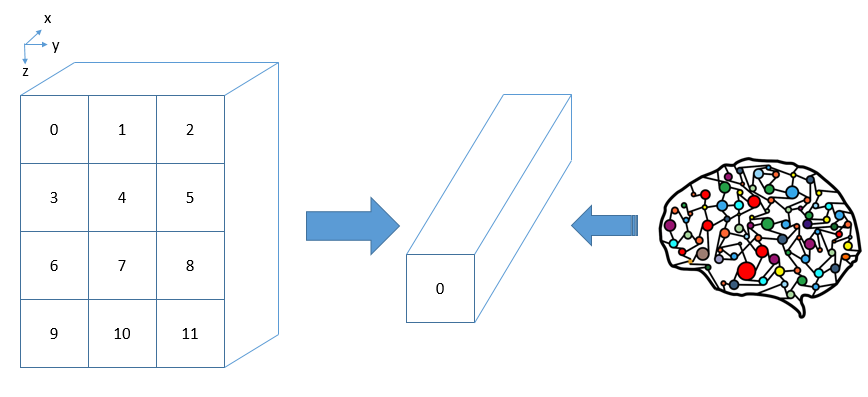

In [47]:
ps = 128 #patch size
lx = int(np.ceil(data_test.shape[0]/ps)*np.ceil(data_test.shape[1]/ps)*data_test.shape[2])
data_test_p = np.zeros([ps,ps,lx],dtype='float32')
label_test_p = np.zeros([ps,ps,lx],dtype='float32')

In [48]:
xx = 0
for x in range(data_test.shape[2]):
  for i in range(int(np.ceil(data_test.shape[0]/ps))):
    for j in range(int(np.ceil(data_test.shape[1]/ps))):
      if i==int(np.ceil(data_test.shape[0]/ps))-1 and j==int(np.ceil(data_test.shape[1]/ps))-1:
        data_test_p[:,:,xx] = data_test[data_test.shape[0]-ps:,data_test.shape[1]-ps:,x]
        label_test_p[:,:,xx] = label_test[data_test.shape[0]-ps:,data_test.shape[1]-ps:,x]
      elif i==int(np.ceil(data_test.shape[0]/ps))-1:
        data_test_p[:,:,xx] = data_test[data_test.shape[0]-ps:,j*ps:j*ps+ps,x]
        label_test_p[:,:,xx] = label_test[data_test.shape[0]-ps:,j*ps:j*ps+ps,x]
      elif j==int(np.ceil(data_test.shape[1]/ps))-1:
        data_test_p[:,:,xx] = data_test[i*ps:i*ps+ps,data_test.shape[1]-ps:,x]
        label_test_p[:,:,xx] = label_test[i*ps:i*ps+ps,data_test.shape[1]-ps:,x]
      else:
        data_test_p[:,:,xx] = data_test[i*ps:i*ps+ps,j*ps:j*ps+ps,x]
        label_test_p[:,:,xx] = label_test[i*ps:i*ps+ps,j*ps:j*ps+ps,x]
      xx=xx+1
data_test_p.shape

(128, 128, 630)

In [ ]:
data_test_np =data_test_p.copy()
label_test_np =label_test_p.copy()


In [ ]:
# save data_test_p and label_test_p
np.save('data_test_np.npy', data_test_np)
np.save('label_test_np.npy', label_test_np)
#save train_np and label_np
np.save('train_np.npy', train_np)
np.save('label_np.npy', label_np)


Now let's check if the tiling data is right.

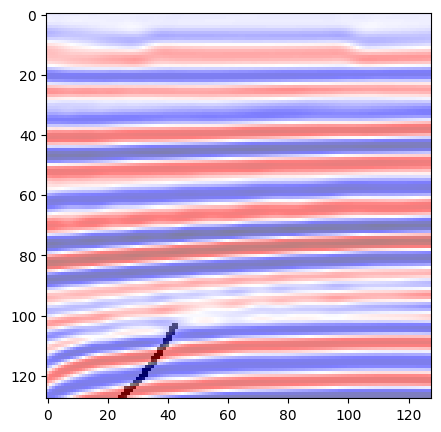

In [72]:
inline=30
fig = plt.figure(figsize=(5,5))
plt.imshow(data_test_p[:,:,inline], cmap='seismic')
plt.imshow(label_test_p[:,:,inline],cmap='Greys',  vmin=0, vmax=1, alpha=0.5)
plt.show()

Great, because we already tiled the data, the test dataset class will be pretty simple.

In [50]:
class seisdataset_test(Dataset):
    def __init__(self, X, y, training=True):
        super().__init__()
        self.X = X.astype('float32')
        self.y = y.astype('float32')

    def __len__(self):
        return self.X.shape[2]

    def __getitem__(self,index):
        data = self.X[:,:,index]
        label = self.y[:,:,index]
        return data[None,:,:], label

---

After the data handling part ready, Now..

Let's put some parameters for our training..

In [51]:
batch_size = 8        #
num_epochs = 150      # its how many times the model learning from all data being fed
num_classes = 2       # its a binary classification, fault/no fault, so its 2.
learning_rate = 0.001 # pretty common things on optimization/inversion problems (especially those who know geophysics)
                      # larger learning rate means faster to converge but you won't find the global optimum and opposite

In [52]:
train_data = seisdataset_train(data_train, label_train)

`shuffle` is for shuffling the dataset, and `drop_last` is for dropping the last dataset that is not evenly divisible by batch size.

In [64]:
def get_data_loaders(batch_size):
    train_data = seisdataset_train(data_train, label_train)
    test_data = seisdataset_test(data_test_p, label_test_p)

    train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, drop_last=True)
    return train_loader,test_loader

In [65]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [55]:
train_loader,test_loader=get_data_loaders(batch_size)

In [57]:
print(len(train_loader))
print(len(test_loader))
print(train_loader.dataset.__len__())
print(test_loader.dataset.__len__())

10
78
80
630


Now, the model architecture that we will use is the famous Unet with little bit of modification.

You can read more about Unet [here](https://arxiv.org/abs/1505.04597) and [here](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47)

Basically the network is like this :

<img src="https://miro.medium.com/max/700/1*OkUrpDD6I0FpugA_bbYBJQ.png"  height="600px" style="padding-bottom:5px;"  />



In [58]:
#https://github.com/milesial/Pytorch-UNet/

import torch.nn.functional as F
import torch.nn as nn
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

After defining the architecture model, now let's put it into the GPU.

Then choose the [loss function](https://en.wikipedia.org/wiki/Loss_function) and [optimizer](https://en.wikipedia.org/wiki/Mathematical_optimization) that we will use (`Adam` with default hyperparameter).

In [59]:
model = UNet(n_channels=1, n_classes=num_classes).to('cuda')
model.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

Using `torchsummary`, we can see the model summary and it's size so we can plan the batch size and such.

In [60]:
from torchsummary import summary
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
        DoubleConv-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14          [-1, 128,

let's test it with random input to see if there is any error.

In [61]:
test = torch.rand(1, 1, 128, 128).cuda()
out = model(test)
out.shape

torch.Size([1, 2, 128, 128])

as you can see, the output 2nd shape size is the number of class that we try to segment.

If it's a 3 class or more, like for example facies classification problem, then it will be 3, etc.

to make it into 2D mask which shows fault / no fault, just find the max indices


In [62]:
lbl_pred = out.data.max(1)[1].cpu().numpy()[:, :, :] #.cpu() because we are currently using the gpu, so transfer to ram cpu first.
lbl_pred[0,:,:].shape

(128, 128)

or some people just `softmax` it then choose their own constraint.

Okay, nothing wrong with the architecture, then next is..

# **Training**

let's get into training part.

Put some empty variable to put our train-test score for future model evaluation.

In [ ]:
train_losses = []
valid_losses = []
train_F1 = []
test_F1 = []
train_acc = []
test_acc = []

Then train it.

The program  below basically just :
1. train the dataset,
2. calculate train loss and score,
3. backward to update the network weights (In geophysics usually called this by 'inversion' part),
4. testing the data set,
5. calculate and updating the test score,
6. repeat till last epoch.

It's gonna take some time so let's watch some youtube's videos.

See you in ten minute-ish!

In [ ]:
for epoch in range(1, num_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    F1_train = 0.0
    acc_train = 0.0
    F1_test = 0.0
    acc_test = 0.0
    model.train()
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(data.float())
        pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        loss = criterion(output, label.long())
        #print(label.shape)
        #print(pred.shape)
        acc = accuracy_score(label.cpu().numpy().flatten(), pred.flatten())
        f1s = f1_score(label.cpu().numpy().flatten(), pred.flatten(),average='binary',zero_division=0)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        F1_train += f1s
        acc_train += acc

    model.eval()
    for data, label in test_loader:

        data = data.to(device)
        label = label.to(device)
        output = model(data.float())
        pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        loss = criterion(output, label.long())
        acc = accuracy_score(label.cpu().numpy().flatten(), pred.flatten())
        f1s = f1_score(label.cpu().numpy().flatten(), pred.flatten(),average='binary',zero_division=0)

        valid_loss += loss.item() * data.size(0)
        F1_test += f1s
        acc_test += acc


    train_loss = train_loss/len(train_loader.sampler)
    F1_train = F1_train/len(train_loader.sampler)*batch_size
    acc_train = acc_train/len(train_loader.sampler)*batch_size
    valid_loss = valid_loss/len(test_loader.sampler)*batch_size
    F1_test = F1_test/len(test_loader.sampler)*batch_size
    acc_test = acc_test/len(test_loader.sampler)*batch_size
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_F1.append(F1_train)
    test_F1.append(F1_test)
    train_acc.append(acc_train)
    test_acc.append(acc_test)
    # print
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tF1_train: {:.6f} \tF1_test: {:.6f}'.format(
        epoch, train_loss, valid_loss, F1_train, F1_test))

---

You can save the model checkpoint for future use or retrain again by using this command :

In [ ]:
torch.save(model.state_dict(), 'model'+str(epoch)+'.ckpt')

..and let's check the model performance from our training

In [ ]:
fig2, ax = plt.subplots(1,3,  figsize=(15,5))
ax[0].plot(train_losses)
ax[1].plot(train_acc)
ax[2].plot(train_F1)
ax[0].plot(valid_losses,'-r')
ax[1].plot(test_acc,'-r')
ax[2].plot(test_F1,'-r')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[2].set_title('F1')
ax[2].legend(("Train", "Test"))
plt.show()

# **Predicting**

---

Now let's test our model prediction :

In [ ]:
inline=10 #inline from test set

slice_test1 = data_test[200:328,150:278,inline]
label_true = label_test[200:328,150:278,inline]

In [ ]:
input_data = torch.from_numpy(slice_test1[None, None, : , :]).float()
output=model(input_data.cuda())
preds=output.data.max(1)[1].cpu().numpy()[0, :, :]

Now some visualization for the result..

In [ ]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(15,15))
ax[0].imshow(slice_test1, cmap='seismic')
ax[1].imshow(label_true, cmap='Greys')
ax[2].imshow(preds, cmap='Greys')
ax[0].set_title('data')
ax[1].set_title('label')
ax[2].set_title('prediction')

plt.show()

As you can see, the model can predict the fault.

---

Let's try to predict one slice patch by patch then!

In [ ]:
import numpy as np
from torch.utils.data import DataLoader
import cv2

from pytorch_toolbelt.inference.tiles import ImageSlicer, CudaTileMerger
from pytorch_toolbelt.utils.torch_utils import tensor_from_rgb_image, to_numpy


img = data_test[:,:,inline]
model.eval()

tiler = ImageSlicer(img.shape, tile_size=(128, 128), tile_step=(64, 64))
merger = CudaTileMerger(tiler.target_shape, 1, tiler.weight)

tiles = [tile for tile in tiler.split(img[:, :, None])]

for tiles_batch, coords_batch in DataLoader(list(zip(tiles, tiler.crops)), batch_size=1):
    tiles_batch = tiles_batch.permute(0, 3, 1, 2)
    output=model(tiles_batch.to(device))
    pred_batch=output.data.max(1)[1]
    merger.integrate_batch(pred_batch, coords_batch)
merged_mask = np.moveaxis(to_numpy(merger.merge()), 0, -1).astype(np.uint8)
merged_mask = tiler.crop_to_orignal_size(merged_mask)
merged_mask=merged_mask[:,:,0]

---

Now, let's see our result.

In [ ]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(15,15))
ax[0].imshow(data_test[:,:,inline], cmap='seismic')
ax[1].imshow(label_test[:,:,inline], cmap='Greys')
ax[2].imshow(merged_mask, cmap='Greys')
ax[0].set_title('data')
ax[1].set_title('label')
ax[2].set_title('prediction')

plt.show()

Not bad! :)

See you again on the next part where we will to try to predict on real data.

# **Exercises**

1. Try to add more augmentations! You can also do precondition the data or add noise. (hint: filter, seismic attributes, elastic deformation)
2. Try using another model architecture! there are other famous model like **PSPnet** and **Deeplab** that you can use!
3. Try adding another layer for feature map extraction before using the unet! (FC, ResNet, etc)
4. Modify the code so it'll save the model at it's best score!
